In [287]:
# Inner Milky Way:
# RA: 20h 32m
# DEC: +37° 58'
# Time: 09:04 (Athens Time)

# Outer Milky Way:
# RA: 05h 20m
# DEC: +38° 00’
# Time: 17:50 (Athens Time)

# Galactic Pole:
# RA: 12h 27m
# Dec: +38° 01’
# Time: 01:01 (Athens Time)

# The systematic total flux density error is 15%, the conversion factor from the arbitrary telescope  flux units is 100 Jy/units.  The rms error must be found from the line-free part of the spectra, which will also be used to find the baseline to fit/subtract from the spectrum. The three questions to answer are:

# 1) How many HI  clouds are apparent within the beam of the telescope

# 2) What are their velocities with respect to us in km/s?

# 3) What is the HI mass in Msol units in the clouds (and the total error)

# A background to the physics of HI line emission must be also given as a context. The report is due by May 13th

In [288]:
import numpy as np  
import os 
from matplotlib import pyplot as plt
import math 
import pandas as pd 
from scipy.stats import linregress
from scipy.integrate import simpson
currentDir,currentFile = os.getcwd(), "spectrum_outer.csv"
pathCsv = os.path.join(currentDir,currentFile)
plt.style.use("bmh")
freqHydrogen = 1420.405751 #Mhz That is the experimental value
c,k_B = 299792458, 1.380649*10**(-23) #m/s
fluxToMass,distanceToCenter = 2.3*10**5, 0.01 #Mpc
#The 21 cm line is at 1,420 Mhz

In [289]:
df = pd.read_csv(pathCsv)
temp = df.to_dict() 
data = {'FREQUENCY' : [],
        'INTENSITY': [],
        'ERROR_INTENSITY': 0.15}
firstCol,lastCol = df.iloc[:, 0] , df.iloc[:, -1]

In [290]:
for frequency, intensity in zip(firstCol,lastCol):
    data['FREQUENCY'].append(frequency)
    data['INTENSITY'].append(intensity*100)

In [291]:
def freqToVel(f):
    return -c*( ( (freqHydrogen/f)**2 -1 )/( (freqHydrogen/f)**2 + 1) )/1000

def convertToSpeed(data):
    freqArray = data['FREQUENCY']
    return {'VELOCITY': [ freqToVel(f) for f in freqArray]}


def plotData(data):
    fig, (ax1,ax2) = plt.subplots(2,1 ,figsize=(8,6))
    
    
    lineY = [i for i in np.linspace(min(data['INTENSITY']),max(data['INTENSITY']),15)]
    lineX = [freqHydrogen for i in range(len(lineY))]
    lineX2 = [0 for i in range(len(lineY))]
    
    ax1.plot(data['FREQUENCY'],data['INTENSITY'], 'r-',label='Frequency')
    ax1.plot(lineX,lineY,linestyle='dotted',label='Original 21cm HL')
    ax2.plot(data['VELOCITY'],data['INTENSITY'], 'b-',label='Velocity')
    ax2.plot(lineX2,lineY,linestyle='dotted',label='Original 21cm HL')
    
    ax1.legend()
    ax2.legend()
    
    ax1.set_xlabel('Frequency (MHz)')
    ax1.set_ylabel('Intensity (Jy)')
    ax2.set_xlabel('Velocity (Km/s)')
    ax2.set_ylabel('Intensity (Jy)')
    
    
    plt.tight_layout()
    plt.savefig(currentFile+".png")
    plt.show()
    
    
def integrateTrapezoid(dataX,dataY):
    dxArray = np.diff(dataX)
    averageY = [(dataY[i]+dataY[i+1])/2 for i in range(len(dataY)-1)]
    result = 0
    for dx, value in zip(dxArray,averageY):
        result += dx * value
    return result

In [292]:
data.update(convertToSpeed(data))

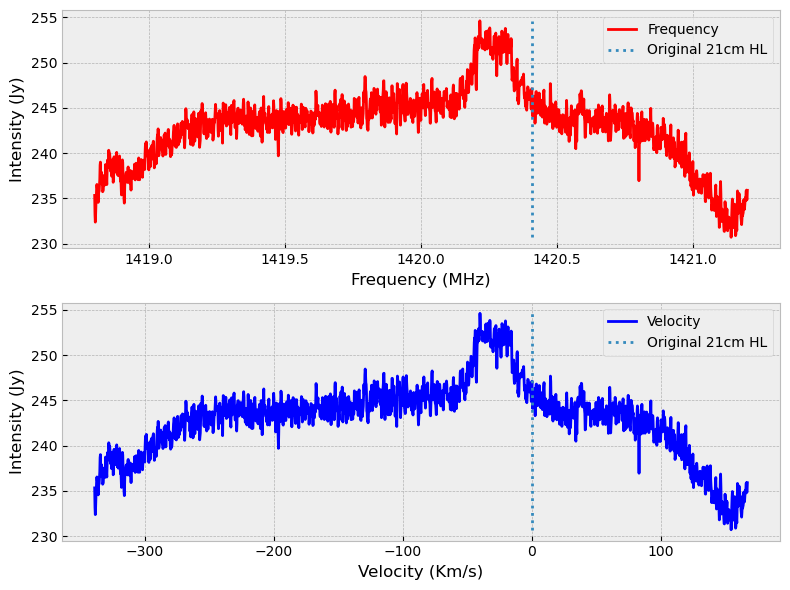

In [293]:
plotData(data)

In [294]:
def findPeaks(data,rangeVal):
    index = np.argmax(data['INTENSITY'][rangeVal[0]:rangeVal[1]:1])
    index = rangeVal[0] + index
    return index, data['VELOCITY'][index], data['FREQUENCY'][index], data['INTENSITY'][index]

peaksArray,rangeVals = [], [[1200,1800]]
for rangeSearch in rangeVals:
    peaksArray.append(findPeaks(data,rangeSearch))

peaksArray #index, velocity,freq,intensity

[(1208, -40.13089607501707, 1420.215625, 254.60739999999998)]

In [295]:
def zoomGraph(data,peak,zoomMinus,zoomPlus):
    plt.scatter(data['VELOCITY'],data['INTENSITY'])
    plt.xlim(data['VELOCITY'][peak-zoomMinus],data['VELOCITY'][peak+zoomPlus])
    plt.show()

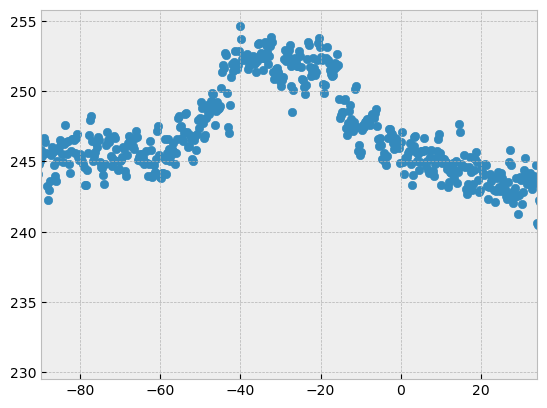

In [296]:
zoomGraph(data,peaksArray[0][0],200,300)

In [297]:
def getBackgroundLine(data,indices):
    X, Y = [], []
    for index in indices:
        X.append(data['VELOCITY'][index])
        Y.append(data['INTENSITY'][index])

    slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    return slope,intercept,std_err

def line(x,slope,inter):
    return x*slope+inter

def getIndices(peak,peakMinus,peakPlus,backgroundMinus,backgroundPlus):
    peakIndices = [i for i in range(peak-peakMinus,peak+peakPlus+1)]
    totalIndices = [i for i in range(peak-backgroundMinus,peak+backgroundPlus+1)]
    
    backgroundIndices = list(set(totalIndices) - set(peakIndices))
    return peakIndices, backgroundIndices, totalIndices


def clearData(data,peak,peakMinus,peakPlus,backgroundMinus,backgroundPlus):
    clearIntensity = []
    totalIndices = getIndices(peak,peakMinus,peakPlus,backgroundMinus,backgroundPlus) #the first result is the peak and the second the background
    slope,intercept,std_err = getBackgroundLine(data,totalIndices[1])
    newVelArray = []
    #Find the clean spectrum for the integral
    for index in totalIndices[0]: # print that range to see what i am doing
        x,y = data['VELOCITY'][index], data['INTENSITY'][index] #remove the background
        clearIntensity.append(y-line(x,slope,intercept))
        newVelArray.append(data['VELOCITY'][index]) 
    #Find the rms
    rms = 0
    for index in totalIndices[1]:
        x,y = data['VELOCITY'][index], data['INTENSITY'][index]
        element = y- line(x,slope,intercept)
        rms += element**2
    return {'VEL_CLEAR':newVelArray,'INT_CLEAR':clearIntensity,'RMS':math.sqrt(rms/len(totalIndices[1])), 'LINE':[slope,intercept]}
    

In [298]:
clearedData = []
values = [200,300,600,600] #peak, background for minus and plus
for peak in peaksArray:
    clearedData.append(clearData(data,peak[0],*values))

In [299]:
def findMass(data,distance): #the distance should be over Mpc
    X, Y = data['VEL_CLEAR'],data['INT_CLEAR']
    area = integrateTrapezoid(X,Y)
    arsim = simpson(y=Y, x=X)
    return fluxToMass*area*(distance**2)

def findMassError(data,distance):
    rms = data['RMS']
    print(rms)
    totalError = [math.sqrt((0.15*element)**2+rms**2) for element in data['INT_CLEAR']]
    area = integrateTrapezoid(data['VEL_CLEAR'],totalError)
    return fluxToMass*area*(distance**2)

In [300]:
#total mass
findMass(clearedData[0],0.01)

9526.594571176105

In [301]:
#total error
findMassError(clearedData[0],0.01)

1.3519925856870438


4271.271447216185

In [302]:
def zoomGraphLine(data,peak,zoomMinus,zoomPlus,slope,intercept):
    plt.scatter(data['VELOCITY'],data['INTENSITY'],label='Data')
    Y = [line(x,slope,intercept) for x in data['VELOCITY']]
    plt.plot(data['VELOCITY'],Y, color='red',label=rf'$y = {slope:0.03f}x + {intercept:0.03f}$')
    plt.xlim(data['VELOCITY'][peak-zoomMinus],data['VELOCITY'][peak+zoomPlus])
    plt.xlabel('Velocity (Km/s)')
    plt.ylabel('Intensity (Jy)')
    plt.title('The zoomed in Peak')
    plt.savefig(currentFile+"zoom"+".png")
    plt.legend()
    plt.show()

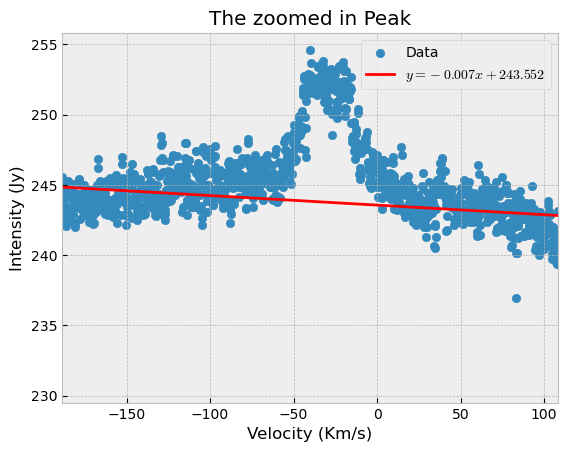

In [303]:
zoomGraphLine(data,peaksArray[0][0],values[2],values[3],clearedData[0]['LINE'][0],clearedData[0]['LINE'][1])